In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
root_path = '/content/gdrive/MyDrive/Dataset'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
# Create Dataset

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    label_mode='categorical',
    seed=123,subset="training",
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    label_mode='categorical',
    seed=123,subset="validation",
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


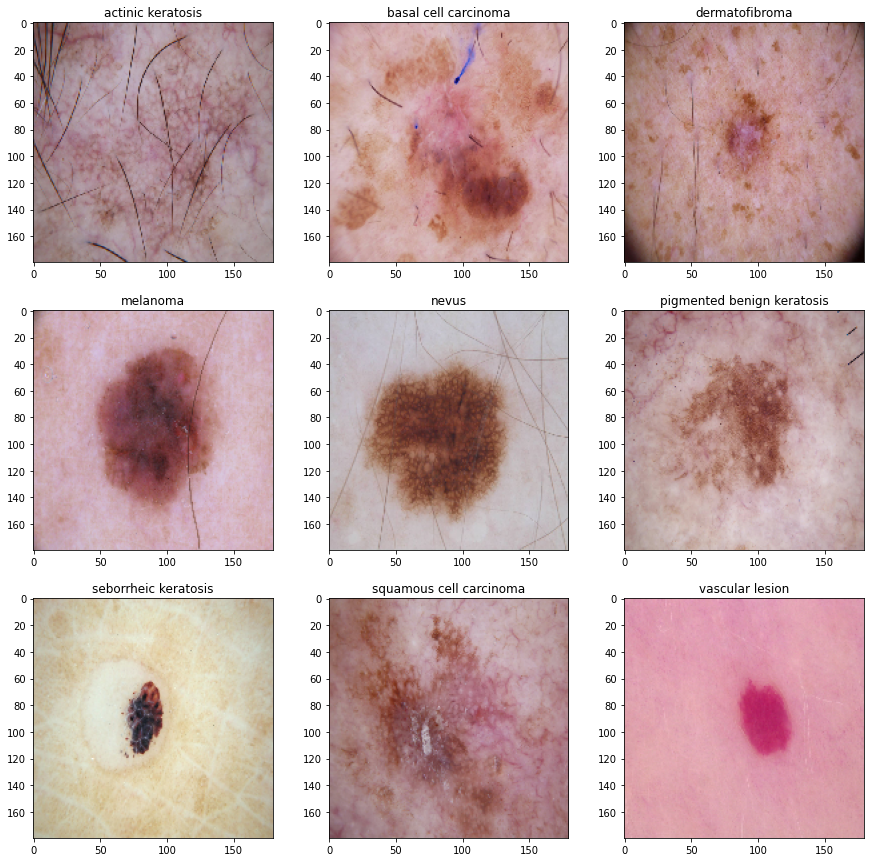

In [11]:
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Model Creation

In [14]:
input_shape = (img_height,img_width,3)

model = Sequential()  

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten()) 


model.add(layers.Dense(512,activation='relu'))

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [15]:
# Compile Model
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 633s 2s/step - loss: 2.0285 - accuracy: 0.2478 - val_loss: 1.8042 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6762 - accuracy: 0.3968 - val_loss: 1.4803 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4672 - accuracy: 0.4676 - val_loss: 1.4444 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4062 - accuracy: 0.5050 - val_loss: 1.4627 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2782 - accuracy: 0.5469 - val_loss: 1.4595 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2104 - accuracy: 0.5603 - val_loss: 1.3809 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.1939 - accuracy: 0.5792 - val_loss: 1.3520 - val_accuracy: 0.5145
Epoch 8/20
56

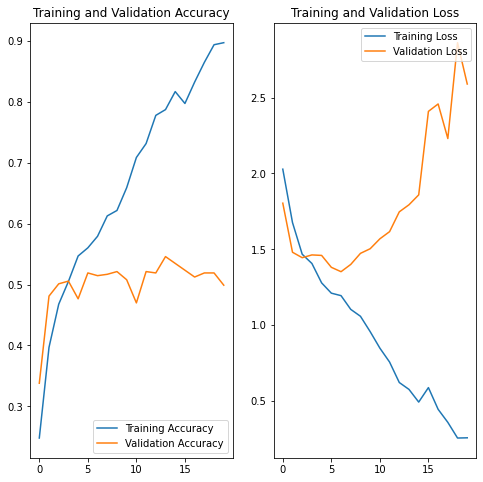

In [18]:
# Visualizing the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# It looks like the model is overfitting

In [20]:
# Using Data sugmentation

In [21]:
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

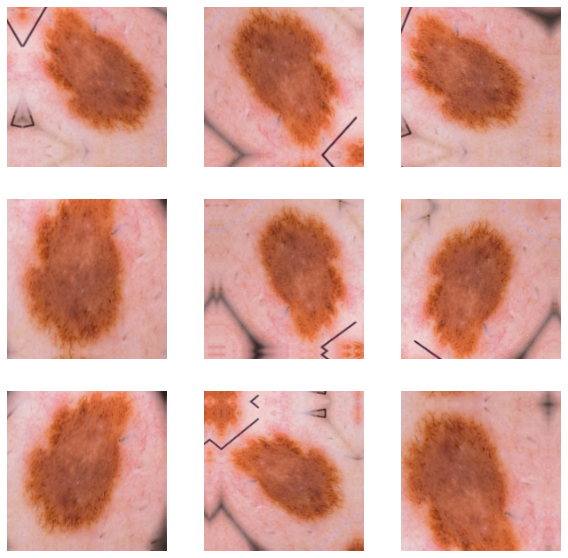

In [22]:
#Visualize the augmentation image
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 

In [23]:
# adding dropout layers to help reduce overfitting

In [24]:
model2 = Sequential()  

model2.add(data_augmentation)
model2.add(rescale)

model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(512,activation='relu'))

model2.add(layers.Dense(128,activation='relu'))

model2.add(layers.Dropout(0.50))

model2.add(layers.Dense(len(class_names),activation='softmax'))

In [25]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [26]:
epochs =20
history = model2.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    verbose=1)

Epoch 1/20


56/56 [==============================] - 13s 161ms/step - loss: 2.4099 - accuracy: 0.1931 - val_loss: 2.0910 - val_accuracy: 0.2148
Epoch 2/20
56/56 [==============================] - 9s 156ms/step - loss: 1.9854 - accuracy: 0.2489 - val_loss: 1.9419 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 9s 159ms/step - loss: 1.8857 - accuracy: 0.2930 - val_loss: 1.8216 - val_accuracy: 0.3579
Epoch 4/20
56/56 [==============================] - 9s 157ms/step - loss: 1.8187 - accuracy: 0.3460 - val_loss: 1.6704 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 9s 157ms/step - loss: 1.7203 - accuracy: 0.3862 - val_loss: 1.8672 - val_accuracy: 0.3512
Epoch 6/20
56/56 [==============================] - 9s 158ms/step - loss: 1.6550 - accuracy: 0.4074 - val_loss: 1.5815 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 9s 157ms/step - loss: 1.6777 - accuracy: 0.4135 - val_loss: 1.6757 - val_accuracy: 0.4452
Epoch 8/20
56/56

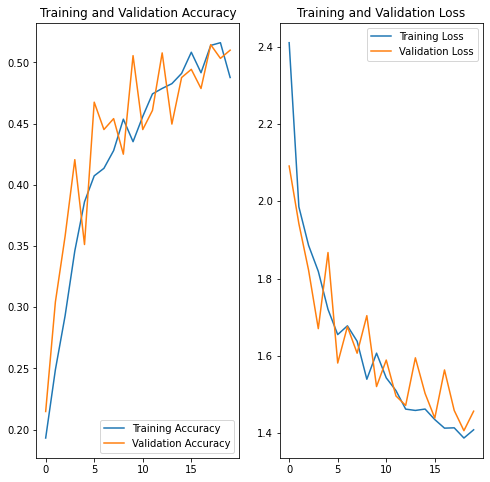

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# We see that Overfitting is reduced but the accuracy is very low

In [29]:
# Checking Class imbalance

In [30]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,melanoma,438
2,actinic keratosis,114
3,pigmented benign keratosis,462
4,dermatofibroma,95
5,seborrheic keratosis,77
6,squamous cell carcinoma,181
7,nevus,357
8,basal cell carcinoma,376


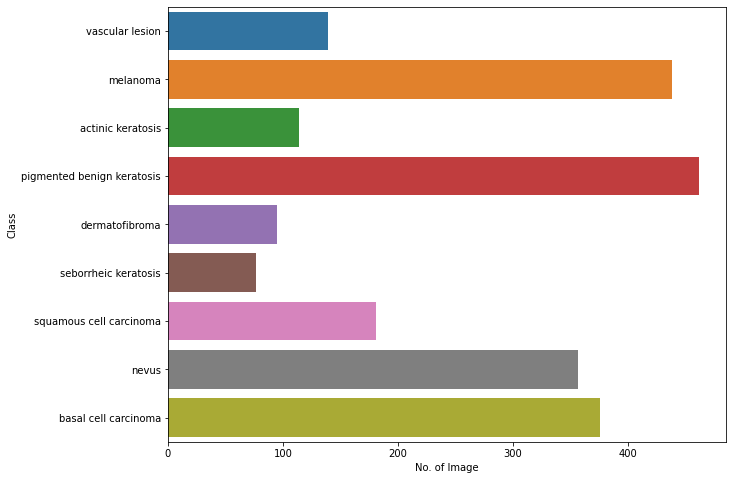

In [31]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [32]:
# Using Augmentor

In [33]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
path_to_training_dataset="/content/gdrive/MyDrive/Dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A465D1690>: 100%|██████████| 500/500 [00:20<00:00, 24.43 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A4615CBD0>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A465D1690>: 100%|██████████| 500/500 [00:17<00:00, 28.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F9AC4A93610>: 100%|██████████| 500/500 [01:22<00:00,  6.06 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A4615CFD0>: 100%|██████████| 500/500 [01:18<00:00,  6.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A49079F90>: 100%|██████████| 500/500 [00:17<00:00, 29.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9A49593F10>: 100%|██████████| 500/500 [00:40<00:00, 12.28 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9AB005BBD0>: 100%|██████████| 500/500 [00:17<00:00, 28.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A495AD1D0>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


In [37]:
# Total number of image generated by augmenter
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [40]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0032775.jpg_0546b92b-c15f-47f9-8992-ac4de5fe5853.jpg',
 '/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_44087414-0f35-4f87-bc1b-503c924fd073.jpg',
 '/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_7b5af61a-eb8b-40d7-b1cc-279e75cc4e3d.jpg',
 '/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0033458.jpg_92c97a80-8499-46c2-894f-406685af6ba1.jpg',
 '/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_9c88a873-a0c8-44e5-80e9-ed5e8c920661.jpg',
 '/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0024662.jpg_cb8cec9f-78d4-4090-a8e4-2b8b809a319a.jpg',
 '/content/gdrive/MyDrive/Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_1132f44

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [43]:
df_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(df_dict_new.items()),columns = ['Path','Label'])

In [46]:
#label count.
df2['Label'].value_counts()

vascular lesion               500
melanoma                      500
actinic keratosis             500
pigmented benign keratosis    500
dermatofibroma                500
seborrheic keratosis          500
squamous cell carcinoma       500
nevus                         500
basal cell carcinoma          500
Name: Label, dtype: int64

In [47]:
data_dir_train="/content/gdrive/MyDrive/Dataset/Train/" 

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [48]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical', 
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [49]:
# Creating Model
model3 = Sequential()

model3.add(rescale)

model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

model3.add(layers.Flatten())

model3.add(layers.Dense(512,activation='relu'))

model3.add(layers.Dropout(0.25))

model3.add(layers.BatchNormalization())

model3.add(layers.Dense(128,activation='relu'))

model3.add(layers.Dropout(0.50))

model3.add(layers.BatchNormalization())

model3.add(layers.Dense(len(class_names),activation='softmax'))

In [50]:
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [51]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 [==============================] - 34s 180ms/step - loss: 2.5303 - accuracy: 0.1727 - val_loss: 6.5001 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 31s 179ms/step - loss: 2.1033 - accuracy: 0.2309 - val_loss: 3.3631 - val_accuracy: 0.1552
Epoch 3/50
169/169 [==============================] - 31s 177ms/step - loss: 1.7467 - accuracy: 0.3377 - val_loss: 2.2422 - val_accuracy: 0.2799
Epoch 4/50
169/169 [==============================] - 31s 180ms/step - loss: 1.6230 - accuracy: 0.3876 - val_loss: 1.8060 - val_accuracy: 0.3311
Epoch 5/50
169/169 [==============================] - 31s 177ms/step - loss: 1.5265 - accuracy: 0.4216 - val_loss: 1.9700 - val_accuracy: 0.3578
Epoch 6/50
169/169 [==============================] - 31s 179ms/step - loss: 1.4673 - accuracy: 0.4410 - val_loss: 1.6556 - val_accuracy: 0.3563
Epoch 7/50
169/169 [==============================] - 31s 177ms/step - loss: 1.4138 - accuracy: 0.4605 - val_loss: 1.8190 - val_ac

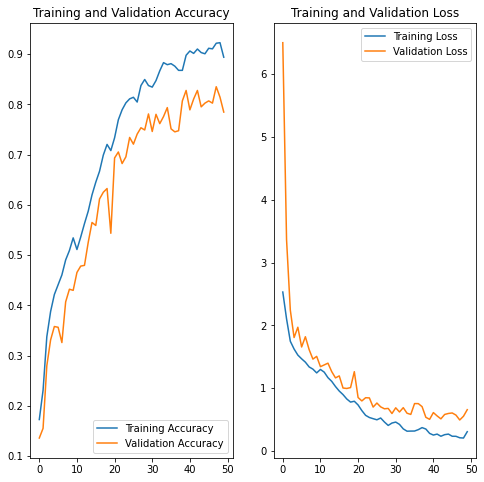

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
'''
We could see that the accuracy increased and there is no overfitting is reduced
'''

'\nWe could see that the accuracy increased and there is no overfitting is reduced\n'